In [1]:
%matplotlib inline 
import numpy as np
import colorednoise as cn
from matplotlib import mlab
from matplotlib import pylab as plt
from scipy.linalg import svd, toeplitz
from scipy.stats import zscore
from statsmodels.tsa.stattools import acf
from infromation_theory_utils import JSD, Entropy, autocorr_coef
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
samples = 10000000 # number of samples to generate

# red noise = 2
red = cn.powerlaw_psd_gaussian(2, samples)
# pink noise = 1
pink = cn.powerlaw_psd_gaussian(1, samples)
# white noise = 0
white = cn.powerlaw_psd_gaussian(0, samples)
# blue noise = -1
blue = cn.powerlaw_psd_gaussian(-1, samples)
# violet noise = -2
violet = cn.powerlaw_psd_gaussian(-2, samples)

noise_dict = {'Red':red, 'Pink':pink, 'White':white, 'Blue':blue, 'Violet':violet}

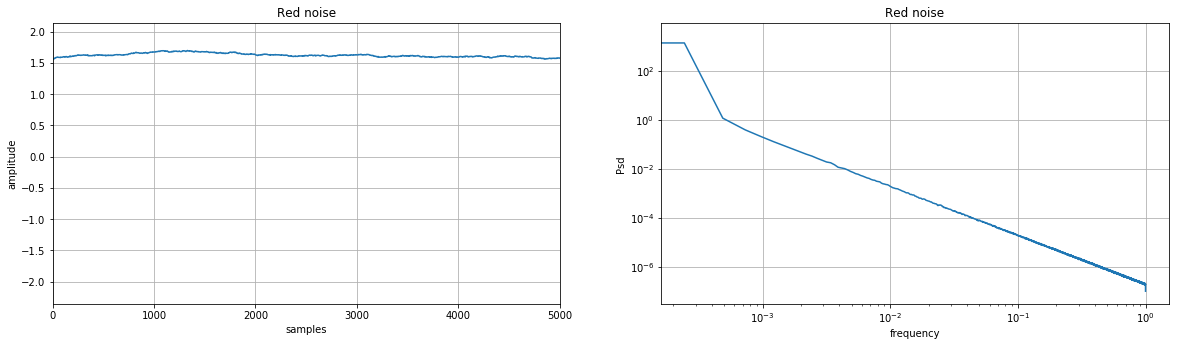

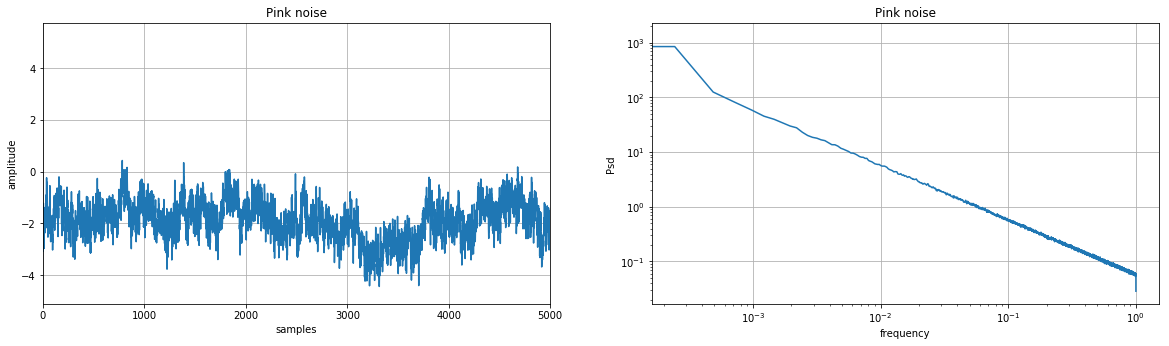

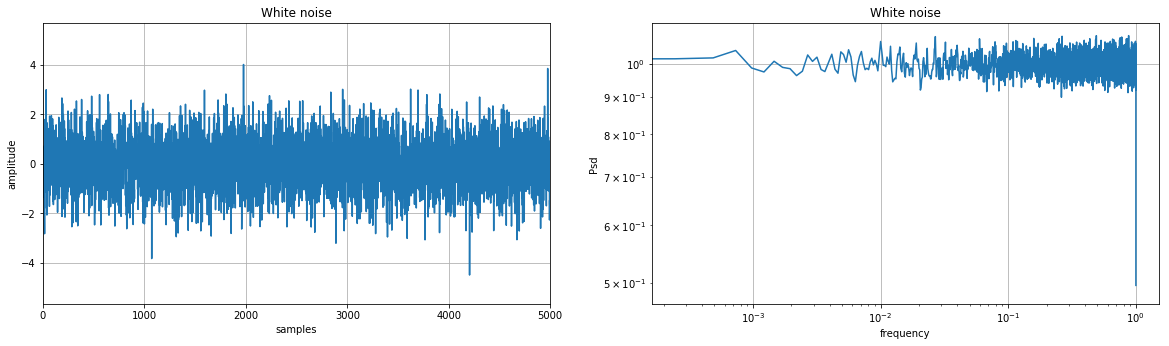

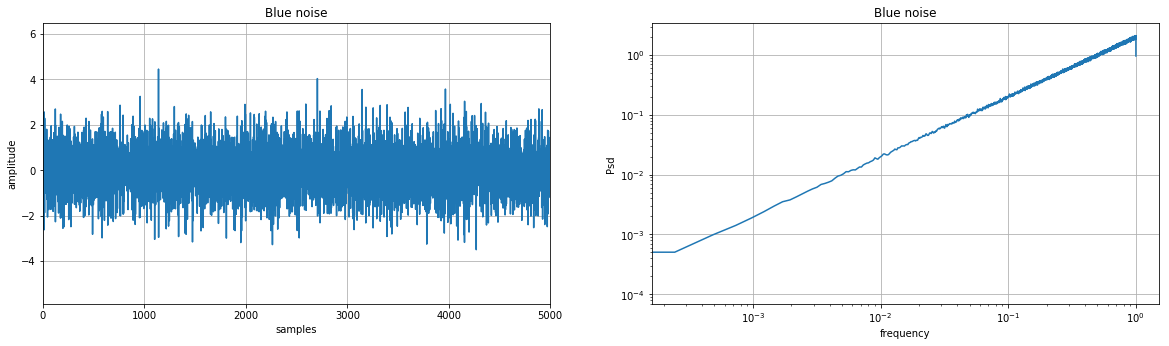

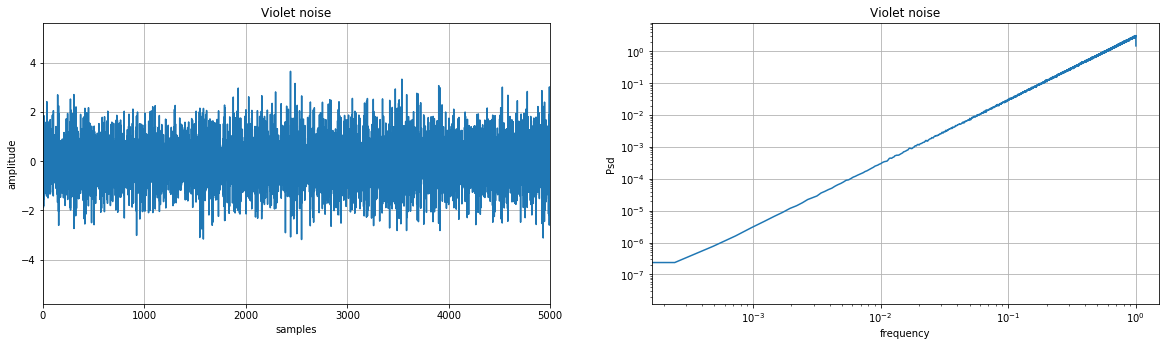

In [3]:
i = 0
for noise in noise_dict.keys():
    i = i+1
    plt.figure(figsize=(20,30))
    plt.subplot(5, 2, i)
    plt.plot(noise_dict[noise])
    plt.xlim([0,5000])
    plt.xlabel('samples')
    plt.ylabel('amplitude')
    plt.title(noise + ' noise')
    plt.grid(True)

    i=i+1
    plt.subplot(5, 2, i)
    s, f = mlab.psd(noise_dict[noise], NFFT=2**13) # optionally plot the Power Spectral Density with Matplotlib
    plt.loglog(f,s)
    plt.xlabel('frequency')
    plt.ylabel('Psd')
    plt.title(noise + ' noise')
    plt.grid(True)
    plt.show()

In [7]:
samples = 200000 # number of samples to generate
iterations = 30
betas = np.arange(0,2.05,0.05)

for lag in tqdm([32, 64, 128, 256, 512, 1024]): # time lag variation
    H = np.zeros((len(betas),iterations))
    D = np.zeros((len(betas),iterations))
    C = np.zeros((len(betas),iterations))
    
    for j in range(iterations): # loop that controls how many times do I iterate to calculate the average
        for i in range(len(betas)): # variation of noise exponents
            colored_noise = cn.powerlaw_psd_gaussian(betas[i], samples)
            x = zscore(colored_noise)
            rxx = acf(x, nlags=lag, unbiased=True, fft=True)
            Sxx = toeplitz(rxx)
            U, s, V = svd(Sxx)      
            H[i,j] = Entropy(s)
            D[i,j] = JSD(s)
            C[i,j] = H[i,j]*D[i,j]

    H = np.mean(H, axis=1)
    D = np.mean(D, axis=1)
    C = np.mean(C, axis=1)
    
    df = pd.DataFrame({ 'Entropy': H, 'Divergency': D, 'Complexity': C })
    df.to_csv('./coloredNoises/coloredNoises_' + str(lag) + '.csv')

print('Done')

100%|██████████| 6/6 [07:02<00:00, 93.65s/it]

Done


### References

%pip install colorednoise

Timmer, J. and Koenig, M.: On generating power law noise. Astron. Astrophys. 300, 707-710 (1995)